In [2]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


df = pd.read_csv("Arrival data.csv")

weekday = df[df['Day']=='Weekday']
saturday = df[df['Day']=='Sat']
sunday = df[df['Day']=='Sun']

In [3]:
def DataManip(data):
    data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))

    # Subtract 8 hours from each time to adjust the range from 0 to 17 hours
    data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
    data['Adjusted Arrival'] = data['Adjusted Arrival'].apply(
        lambda x: x + pd.Timedelta(days=1) if x.total_seconds() < 0 else x)
    
    data = data.rename(columns={"Week ": "Day_Number", "Day": "Day_Type"})
    return data

# Function to calculate interarrival times
def calculate_interarrival(group):
    # Shift the 'Adjusted Arrival' column to get the difference with the previous row
    interarrival = group['Adjusted Arrival'].diff()

    # For the first row of each group, use the 'Adjusted Arrival' time itself
    interarrival.iloc[0] = group['Adjusted Arrival'].iloc[0]

    # Convert interarrival times to seconds
    return interarrival.dt.total_seconds()

weekday = DataManip(weekday)
weekday['Interarrival Time (sec)'] = weekday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

saturday = DataManip(saturday)
saturday['Interarrival Time (sec)'] = saturday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

sunday = DataManip(sunday)
sunday['Interarrival Time (sec)'] = sunday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)


C:\Users\wesle\AppData\Local\Temp\ipykernel_7696\3593575078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))
C:\Users\wesle\AppData\Local\Temp\ipykernel_7696\3593575078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
C:\Users\wesle\AppData\Local\Temp\ipykernel_7696\3593575078.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [4]:
def calculate_lambda_per_hour(data):
    # Convert 'Arrival' to timedelta
    data['Adjusted Arrival'] = pd.to_timedelta(data['Adjusted Arrival'])

    # Extract hour from 'Arrival'
    data['Hour'] = data['Adjusted Arrival'].dt.components.hours
    # Initialize a dictionary to store lambda values for each hour
    lambda_per_hour = {hour: [] for hour in range(0, 17)}

    for hour in range(0, 17):
        hour_data = data[data['Hour'] == hour]
        if not hour_data.empty:
            mean_interarrival = hour_data['Interarrival Time (sec)'].mean()
            lambda_hour_day = 1 / mean_interarrival if mean_interarrival > 0 else 0
            lambda_per_hour[hour] = (lambda_hour_day)
            
    return lambda_per_hour

lambdas_weekday = calculate_lambda_per_hour(weekday)
lambdas_saturday = calculate_lambda_per_hour(saturday)
lambdas_sunday = calculate_lambda_per_hour(sunday)



In [5]:
# Convert the dictionaries to DataFrames
df_weekday = pd.DataFrame(list(lambdas_weekday.items()), columns=['Hour', 'Lambda'])
df_saturday = pd.DataFrame(list(lambdas_saturday.items()), columns=['Hour', 'Lambda'])
df_sunday = pd.DataFrame(list(lambdas_sunday.items()), columns=['Hour', 'Lambda'])

# Ensure hours are aligned
hours = sorted(set(df_weekday['Hour']) | set(df_saturday['Hour']) | set(df_sunday['Hour']))
df_weekday = df_weekday.set_index('Hour').reindex(hours).reset_index()
df_saturday = df_saturday.set_index('Hour').reindex(hours).reset_index()
df_sunday = df_sunday.set_index('Hour').reindex(hours).reset_index()

df_weekday['Lambda'] = df_weekday['Lambda']*60*60
df_saturday['Lambda'] = df_saturday['Lambda']*60*60
df_sunday['Lambda'] = df_sunday['Lambda']*60*60

In [9]:
def erlang_c(c, rho):
    p0 = 0
    for i in range(c):
        p0 += (c*rho)**i/math.factorial(i) + (c*rho)**c/math.factorial(c)*(1/(1-rho))
        
    pc = (c*rho)**c/(math.factorial(c) * p0)
    return pc/(1-rho)

def load(df, c, ES):
    return (df['Lambda']/60)/(c*(1/ES))


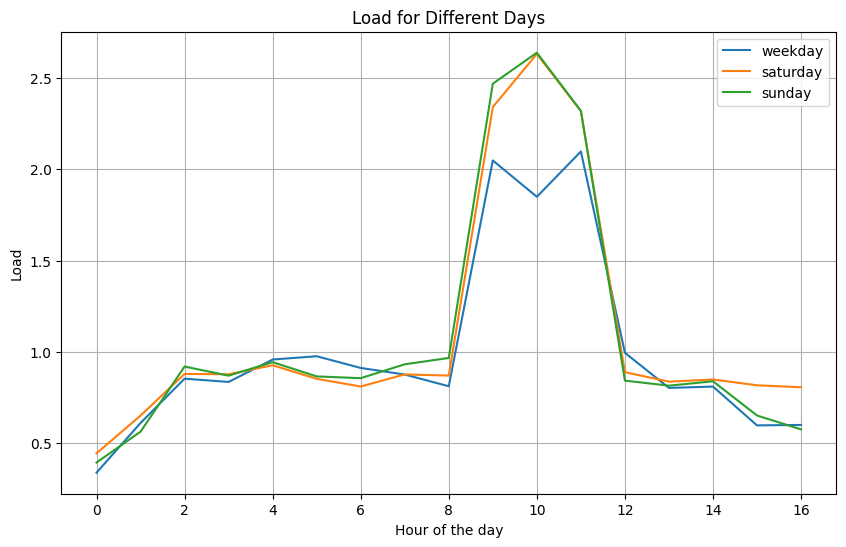

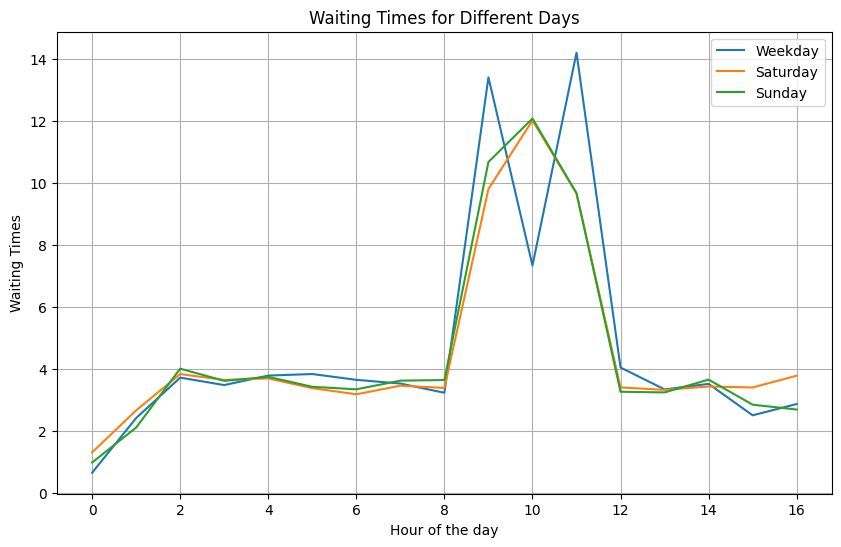

1155 1425 1350


In [10]:
#old method

# Convert the dictionaries to DataFrames
df_weekday = pd.DataFrame(list(lambdas_weekday.items()), columns=['Hour', 'Lambda'])
df_saturday = pd.DataFrame(list(lambdas_saturday.items()), columns=['Hour', 'Lambda'])
df_sunday = pd.DataFrame(list(lambdas_sunday.items()), columns=['Hour', 'Lambda'])

# Ensure hours are aligned
hours = sorted(set(df_weekday['Hour']) | set(df_saturday['Hour']) | set(df_sunday['Hour']))
df_weekday = df_weekday.set_index('Hour').reindex(hours).reset_index()
df_saturday = df_saturday.set_index('Hour').reindex(hours).reset_index()
df_sunday = df_sunday.set_index('Hour').reindex(hours).reset_index()

df_weekday['Lambda'] = df_weekday['Lambda']*60*60
df_saturday['Lambda'] = df_saturday['Lambda']*60*60
df_sunday['Lambda'] = df_sunday['Lambda']*60*60

ES = 3.25

cost = 15

#load < 1
# c = {
#     "weekday": {0:4,1:4,2:4,3:5,4:6,5:6,6:6,7:6,8:7,9:7,10:8,11:8,12:5,13:5,14:4,15:3,16:2},
#     "saturday": {0:4,1:4,2:4,3:5,4:6,5:7,6:8,7:7,8:8,9:10,10:11,11:10,12:9,13:7,14:6,15:5,16:3},
#     "sunday": {0:4,1:4,2:4,3:5,4:6,5:7,6:8,7:7,8:8,9:10,10:11,11:10,12:9,13:7,14:4,15:3,16:2}
# }

#load > 1
c = {
    "weekday": {0:4,1:4,2:4,3:5,4:6,5:6,6:6,7:6,8:7,     9:3,10:4,11:3,       12:5,13:5,14:4,15:3,16:2},
    "saturday": {0:4,1:4,2:4,3:5,4:6,5:7,6:8,7:7,8:8,    9:4,10:4,11:4,    12:9,13:7,14:6,15:5,16:3},
    "sunday": {0:4,1:4,2:4,3:5,4:6,5:7,6:8,7:7,8:8,      9:4,10:4,11:4,    12:9,13:7,14:4,15:3,16:2}
}

#all 8
# c = {
#     "weekday": {0:8,1:8,2:8,3:8,4:8,5:8,6:8,7:8,8:8,     9:8,10:8,11:8,       12:8,13:8,14:8,15:8,16:8},
#     "saturday": {0:8,1:8,2:8,3:8,4:8,5:8,6:8,7:8,8:8,    9:8,10:8,11:8,    12:8,13:8,14:8,15:8,16:8},
#     "sunday": {0:8,1:8,2:8,3:8,4:8,5:8,6:8,7:8,8:8,      9:8,10:8,11:8,    12:8,13:8,14:8,15:8,16:8}
# }

weekday_cost = sum(c["weekday"].values())*cost
saturday_cost = sum(c["saturday"].values())*cost
sunday_cost = sum(c["sunday"].values())*cost

def calculate_c(c_dict, df_type, hour):
    # Define a function to retrieve 'c' based on the dataframe type and hour from the dictionary
    return c_dict[df_type][hour]

for df_type, df in [("weekday", df_weekday), ("saturday", df_saturday), ("sunday", df_sunday)]:
    # Assuming your dataframe has a column named 'Hour' representing the hour of the day
    df["Load"] = df.apply(lambda row: load(row, calculate_c(c, df_type, row['Hour']), ES), axis=1)

# Convert 'c' dictionary to DataFrames and add 'c' as a column in each dataframe
for df, c_value in zip([df_weekday, df_saturday, df_sunday], [c["weekday"], c["saturday"], c["sunday"]]):
    df['c'] = df['Hour'].map(c_value)
    
# Plotting 'Load' values for all three dataframes in a single figure
plt.figure(figsize=(10, 6))  # Set the figure size
for df_type, df in [("weekday", df_weekday), ("saturday", df_saturday), ("sunday", df_sunday)]:
    plt.plot(df['Hour'], df['Load'], label=df_type)  # Plot 'Load1' against 'Hour' for each dataframe

plt.xlabel('Hour of the day')
plt.ylabel('Load')
plt.title('Load for Different Days')
plt.legend()
plt.grid(True)
plt.show()

def waiting_times(df):
    ES1 = 3.25
    EW = []
    for i in df.index:
        rho = df.at[i, 'Load']
        c_real = df.at[i, 'c']
        EW1 = (erlang_c(c_real, rho) / (1 / c_real * (1 / ES1))) / (1 - (rho / c_real))
        EW.append(EW1)
    return EW

waiting_times_weekday = waiting_times(df_weekday)
waiting_times_saturday = waiting_times(df_saturday)
waiting_times_sunday = waiting_times(df_sunday)

# Plotting waiting times for all three dataframes in a single figure
plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(df_weekday['Hour'], waiting_times_weekday, label='Weekday')
plt.plot(df_saturday['Hour'], waiting_times_saturday, label='Saturday')
plt.plot(df_sunday['Hour'], waiting_times_sunday, label='Sunday')

plt.xlabel('Hour of the day')
plt.ylabel('Waiting Times')
plt.title('Waiting Times for Different Days')
plt.legend()
plt.grid(True)
plt.show()

print(weekday_cost,saturday_cost,sunday_cost)

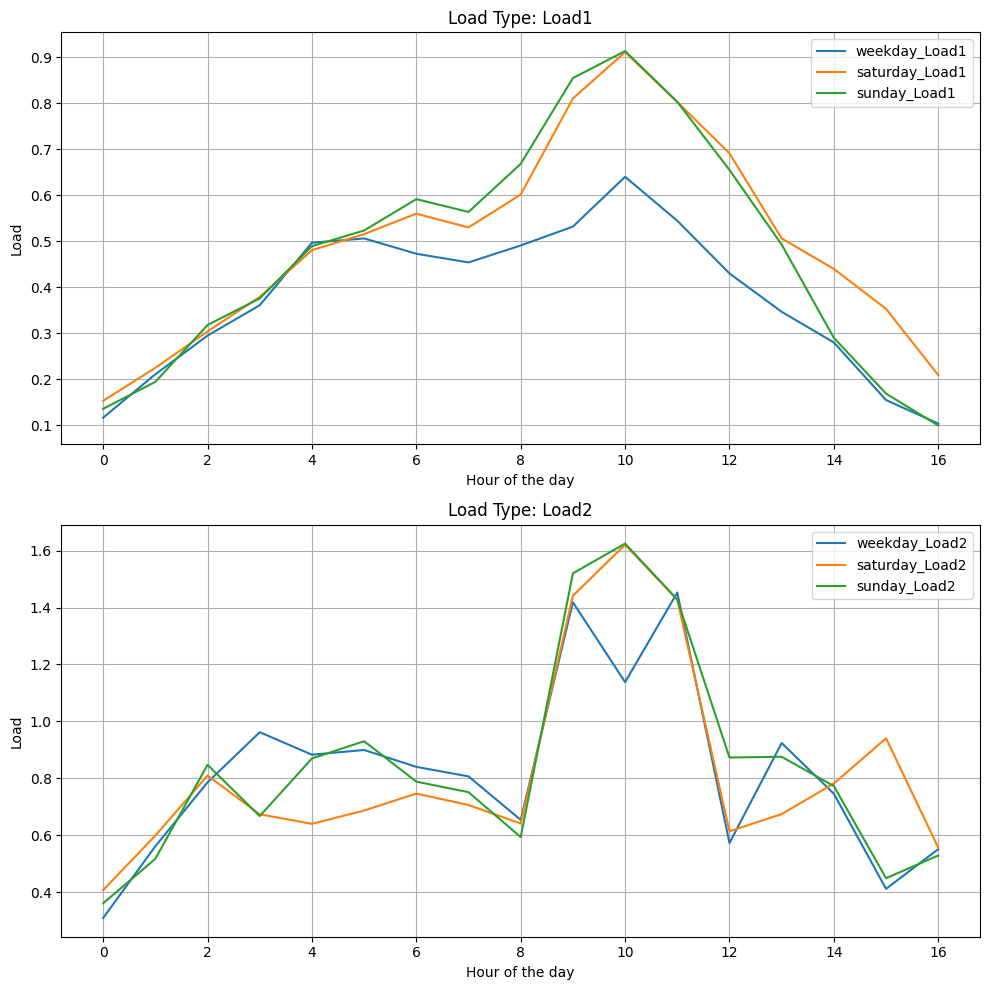

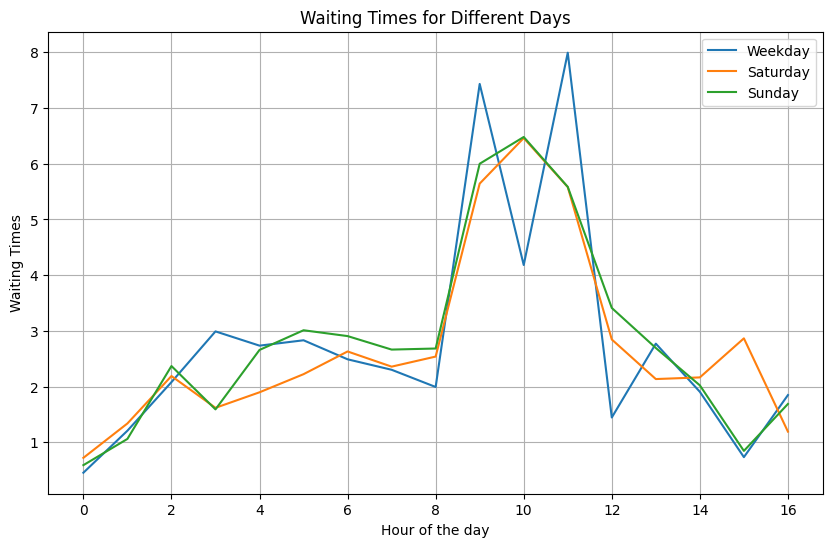

630 840 750


In [11]:
#new method
# Convert the dictionaries to DataFrames
df_weekday = pd.DataFrame(list(lambdas_weekday.items()), columns=['Hour', 'Lambda'])
df_saturday = pd.DataFrame(list(lambdas_saturday.items()), columns=['Hour', 'Lambda'])
df_sunday = pd.DataFrame(list(lambdas_sunday.items()), columns=['Hour', 'Lambda'])

# Ensure hours are aligned
hours = sorted(set(df_weekday['Hour']) | set(df_saturday['Hour']) | set(df_sunday['Hour']))
df_weekday = df_weekday.set_index('Hour').reindex(hours).reset_index()
df_saturday = df_saturday.set_index('Hour').reindex(hours).reset_index()
df_sunday = df_sunday.set_index('Hour').reindex(hours).reset_index()

df_weekday['Lambda'] = df_weekday['Lambda']*60*60
df_saturday['Lambda'] = df_saturday['Lambda']*60*60
df_sunday['Lambda'] = df_sunday['Lambda']*60*60

ES1 = 2.25
ES2 = 1.5
cost = 15
c1 = 8
#load < 1
# c = {
#     "weekday": {0:2,1:2,2:2,3:2,4:3,5:3,6:3,7:3,8:4,9:4,10:4,11:4,12:4,13:2,14:2,15:2,16:1},
#     "saturday": {0:2,1:2,2:2,3:3,4:4,5:4,6:4,7:4,8:5,9:6,10:6,11:6,12:6,13:4,14:3,15:2,16:2},
#     "sunday": {0:2,1:2,2:2,3:3,4:3,5:3,6:4,7:4,8:6,9:5,10:5,11:5,12:4,13:3,14:2,15:2,16:1}
# }

# #load > 1
# c = {
c = {
    "weekday": {0:2,1:2,2:2,3:2,4:3,5:3,6:3,7:3,8:4,     9:2,10:3,11:2,    12:4,13:2,14:2,15:2,16:1},
    "saturday": {0:2,1:2,2:2,3:3,4:4,5:4,6:4,7:4,8:5,    9:3,10:3,11:3,    12:6,13:4,14:3,15:2,16:2},
    "sunday": {0:2,1:2,2:2,3:3,4:3,5:3,6:4,7:4,8:6,      9:3,10:3,11:3,    12:4,13:3,14:2,15:2,16:1}
}

weekday_cost = sum(c["weekday"].values())*cost
saturday_cost = sum(c["saturday"].values())*cost
sunday_cost = sum(c["sunday"].values())*cost

def calculate_c(c_dict, df_type, hour):
    # Define a function to retrieve 'c' based on the dataframe type and hour from the dictionary
    return c_dict[df_type][hour]

for df_type, df in [("weekday", df_weekday), ("saturday", df_saturday), ("sunday", df_sunday)]:
    # Assuming your dataframe has a column named 'Hour' representing the hour of the day
    df["Load1"] = load(df, c1, ES1)
    df["Load2"] = df.apply(lambda row: load(row, calculate_c(c, df_type, row['Hour']), ES2), axis=1)

# Convert 'c' dictionary to DataFrames and add 'c' as a column in each dataframe
for df, c_value in zip([df_weekday, df_saturday, df_sunday], [c["weekday"], c["saturday"], c["sunday"]]):
    df['c2'] = df['Hour'].map(c_value)
    
# Plotting 'Load' values for all three dataframes in a single figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))  # Create subplots for Load1 and Load2

load_types = ['Load1', 'Load2']

for i, load_type in enumerate(load_types):
    ax = axes[i]  # Select the current subplot
    for df_type, df in [("weekday", df_weekday), ("saturday", df_saturday), ("sunday", df_sunday)]:
        ax.plot(df['Hour'], df[load_type], label=f'{df_type}_{load_type}')  # Plot load_type against 'Hour' for each dataframe

    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Load')
    ax.set_title(f'Load Type: {load_type}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()  # Adjust subplot layout for better appearance
plt.show()

def waiting_times(df):
    EW = []
    for i in df.index:
        rho1 = df.at[i, 'Load1']
        rho2 = df.at[i, 'Load2']
        c2 = df.at[i, 'c2']
        EW1 = (erlang_c(c1, rho1) / (1 / c1 * (1 / ES1))) / (1 - (rho1 / c1))
        EW2 = (erlang_c(c2, rho2) / (1 / c2 * (1 / ES2))) / (1 - (rho2 / c2))
        EW.append(EW1+EW2)
    return EW

waiting_times_weekday = waiting_times(df_weekday)
waiting_times_saturday = waiting_times(df_saturday)
waiting_times_sunday = waiting_times(df_sunday)

# Plotting waiting times for all three dataframes in a single figure
plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(df_weekday['Hour'], waiting_times_weekday, label='Weekday')
plt.plot(df_saturday['Hour'], waiting_times_saturday, label='Saturday')
plt.plot(df_sunday['Hour'], waiting_times_sunday, label='Sunday')

plt.xlabel('Hour of the day')
plt.ylabel('Waiting Times')
plt.title('Waiting Times for Different Days')
plt.legend()
plt.grid(True)
plt.show()

print(weekday_cost,saturday_cost,sunday_cost)